In [4]:
import awk_data
import awkward as ak
import tensorflow as tf
import loader
import argparse 
from collections import defaultdict
import os, json
import importlib.util
from time import time
import numpy as np
from plotting import * 
import plot_loss


model_file = "models_archive/model_ACAT22.py"
config_json = "training_config/training_config_awk_t3psi.json"

# Load the model and dataset

In [5]:

config = json.load(open(config_json))

config['activation'] = tf.keras.activations.get(config['activation'])

# Checking hardware
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
gpus =  tf.config.list_physical_devices('GPU')

# if len(gpus) ==1 :
#     print("Using 1 GPU")
#     tf.config.experimental.set_memory_growth(gpus[0], enable=True)
#     strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# elif len(gpus):
#     print("Using {} GPUs".format(len(gpus)))
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, enable=True)
#     strategy = tf.distribute.MirroredStrategy()
# else:
#     strategy = tf.distribute.OneDeviceStrategy("cpu:0")
if len(gpus) >=1 :
    print("Using 1 GPU")
    #tf.config.experimental.set_memory_growth(gpus[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")


##################
# Prepare the output folder
def get_unique_run():
    previous_runs = os.listdir(config["models_path"])
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

if not os.path.isdir(config["models_path"]):
    os.makedirs(config["models_path"])

name =  'run_{:02}'.format(get_unique_run())

outdir = config["models_path"] + "/"+ name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print("Model output folder: ", outdir)

############################3
#Copying the config file and model file in the output dir:
os.system("cp {} {}".format(config_json, outdir))
os.system("cp {} {}".format(model_file, outdir))

###########################
## Loading the datasets
print(">>> Loading datasets")

train_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["training"]))
test_ds = awk_data.load_dataset(awk_data.LoaderConfig(**config["dataset_conf"]["validation"]))
# Create training and validation
ds_train = train_ds.prefetch(tf.data.AUTOTUNE).repeat(config['nepochs'])
ds_test  = test_ds.prefetch(tf.data.AUTOTUNE).repeat(config['nepochs'])

version=2.10.0, CUDA=True, GPU=False
Model output folder:  /work/dvalsecc/Clustering/models_archive/gcn_models/ACAT2021_v2/tests/run_27
>>> Loading datasets


In [6]:
############### 
# Loading the model file
 # Load model modules
spec = importlib.util.spec_from_file_location("model", model_file)
model_lib = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model_lib)

tf.keras.backend.clear_session()
# Construction of the model in the strategy scope
with strategy.scope():
    print(">>> Creating the model")
    # Build the model with all the configs
    model = model_lib.DeepClusterGN(**config)

    #optimizer
    if config['opt'] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])

    #compile the model
    model.compile(optimizer=opt)
    model.set_metrics()

    for X, y ,w  in ds_train:
        # Load the model
        ypred = model(X, training=False)
        #l = custom_loss(y, ypred)
        break

    model.summary()
    

>>> Creating the model


2022-09-29 14:21:08.050149: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48234496 exceeds 10% of free system memory.
2022-09-29 14:21:08.354378: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48234496 exceeds 10% of free system memory.
2022-09-29 14:21:08.372110: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48234496 exceeds 10% of free system memory.
2022-09-29 14:21:08.403626: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48234496 exceeds 10% of free system memory.
2022-09-29 14:21:08.419151: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48234496 exceeds 10% of free system memory.


Model: "deep_cluster_gn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_builder (GraphBuildin  multiple                 78267     
 g)                                                              
                                                                 
 GHN_global (GHConvI)        multiple                  8256      
                                                                 
 SA_clclass (SelfAttentionBl  multiple                 24960     
 ock)                                                            
                                                                 
 dense_clclass (Sequential)  (512, 23, 1)              90753     
                                                                 
 SA_windclass (SelfAttention  multiple                 41344     
 Block)                                                          
                                                   

## Evaluating the model

In [7]:
X, ytrue, w = next(iter(ds_train))

In [8]:
ypred = model(X)

# Check losses

### Classification loss

In [9]:
(dense_clclass, dense_windclass, en_regr_factor),  mask_cls, _  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue        
class_loss = tf.keras.losses.binary_crossentropy(y_clclass[:,:,tf.newaxis], dense_clclass, from_logits=True) * mask_cls
# This should be replaced by the mean over the not masked elements
reduced_loss = tf.reduce_sum(tf.reduce_mean(class_loss, axis=-1) * w) / tf.reduce_sum(w)
# reduced_loss = tf.reduce_sum(tf.reduce_sum(class_loss, axis=-1) * weight / tf.reduce_sum) / tf.reduce_sum(weight)

In [13]:
%%timeit
class_loss*mask_cls

57 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
old_loss = tf.reduce_mean(class_loss, axis=-1)
correct_loss = tf.reduce_sum(class_loss, axis=-1) / tf.reduce_sum(mask_cls, axis=-1)
ncls = tf.reduce_sum(mask_cls, axis=-1)

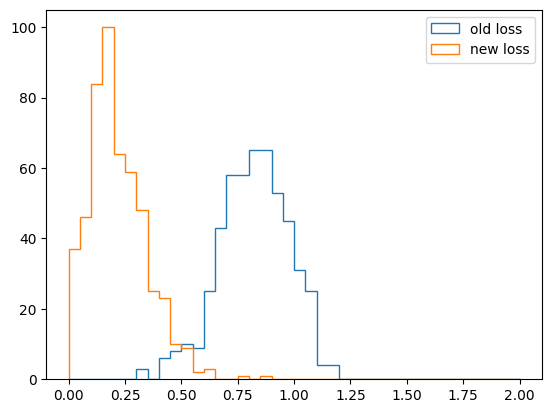

In [30]:
plt.hist(correct_loss, bins=40, range=(0,2), histtype="step", label="old loss")
plt.hist(old_loss, bins=40, range=(0,2), histtype="step", label="new loss")
plt.legend()

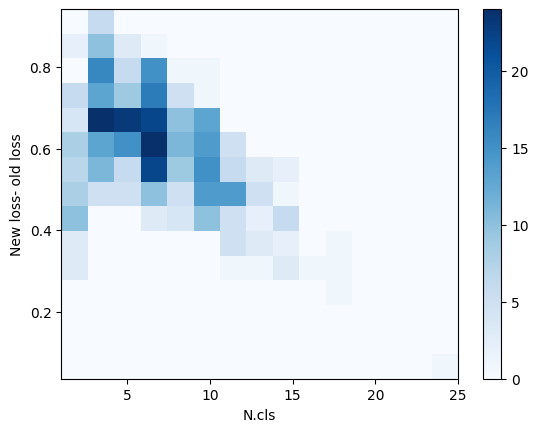

In [29]:
plt.hist2d(ncls, correct_loss- old_loss, bins=15, cmap="Blues")
plt.xlabel('N.cls')
plt.ylabel("New loss- old loss")
plt.colorbar()

### SoftF1 classification loss

In [21]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls, _  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue
y_target = tf.cast(y_clclass, tf.float32)[:,:,tf.newaxis]
beta = 1.5
# matched_window = tf.cast(y_metadata[:,-1]!=0, tf.float32)

pred_prob = tf.nn.sigmoid(dense_clclass)*mask_cls[:,:,None]
tp = tf.reduce_sum(pred_prob * y_target, axis=1)
fn = tf.reduce_sum((1 - pred_prob) * y_target, axis=1)
fp = tf.reduce_sum(pred_prob * (1 - y_target), axis=1)

soft_f1_loss = 1 - ((1 + beta**2) * tp)/ ( (1+beta**2)*tp + beta* fn + fp + 1e-16) 
reduced_f1 = tf.reduce_sum(tf.squeeze(soft_f1_loss) * w) / tf.reduce_sum(w) 

In [13]:
reduced_f1

<tf.Tensor: shape=(), dtype=float32, numpy=0.83908993>

In [22]:
reduced_f1

<tf.Tensor: shape=(), dtype=float32, numpy=0.6080681>

### Energy losses

In [19]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls,_  = ypred
y_clclass, y_windclass, cl_X, wind_X, y_metadata = ytrue
y_target = tf.cast(y_clclass, tf.float32)[:,:,tf.newaxis]
cl_en = Et = cl_X[:,:,0:1]
En_sim_good = y_metadata[:,-1]
pred_prob = tf.nn.sigmoid(dense_clclass)*mask_cls[:,:,None] ### Masking???

sel_en = tf.squeeze(tf.reduce_sum(cl_en * pred_prob , axis=1))
en_resolution_loss =  tf.reduce_sum(tf.square( (sel_en/En_sim_good) - 1) * w ) / tf.reduce_sum(w) 

In [15]:
pred_prob = tf.nn.sigmoid(dense_clclass)

In [20]:
sel_en[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 40.781246 ,   8.586252 ,  77.36955  , 209.33183  , 125.014755 ,
       150.6446   ,  25.79868  ,  27.82602  ,   4.7211885,   6.227814 ],
      dtype=float32)>

In [21]:
sel_en[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 40.781246 ,   8.586252 ,  77.36955  , 209.33183  , 125.014755 ,
       150.6446   ,  25.79868  ,  27.82602  ,   4.7211885,   6.227814 ],
      dtype=float32)>

## Training

In [9]:
import tensorflow_model_optimization as tfmot
initial_sparsity = 0.0
final_sparsity = 0.75
begin_step = 200
end_step = 300
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity,
        begin_step=begin_step,
        end_step=end_step)
}

In [10]:
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()

ValueError: `prune_low_magnitude` can only prune an object of the following types: tf.keras.models.Sequential, tf.keras functional model, tf.keras.layers.Layer, list of tf.keras.layers.Layer. You passed an object of type: DeepClusterGN.

In [12]:
help(model)

Help on DeepClusterGN object:

class DeepClusterGN(keras.engine.training.Model)
 |  DeepClusterGN(*args, **kwargs)
 |  
 |  Model parameters:
 |  - activation
 |  - output_dim_nodes: latent space dimension for clusters node built from rechits and cluster features
 |  - output_dim_rechits:  latent space dimension for the rechits per-cluster feature vector
 |  - output_dim_gconv: output of the graph convolution (default==output_dim_nodes)    - output_dim_sa_clclass: output of the self-attention layer for cluster classification (default==output_dim_gconv)
 |  - output_dim_sa_windclass: output of the self-attention layer for windows classification (default==output_dim_gconv)
 |  - coord_dim:  coordinated space dimension
 |  - nconv_rechits: number of convolutions for the rechits GCN
 |  - nconv: number of convolutions for the global model
 |  - layers_input:  list representing the DNN applied on the [rechit+cluster] concatened features to build the clusters latent space
 |  - layers_clclas